# Setup

In [1]:
from pylab import *
from numpy import *
from scipy.signal import lfilter

pars = {}
pars['Tfilt'] = 100 # length of filter in ms
pars['dt'] = 0.1 # timestep in ms/step
pars['Tlong']=5000 # length of long injections in ms
pars['range_t'] = np.arange(0, pars['Tlong'], pars['dt'])

def DesignExponentialFilter(pars,tau):
  t = arange(0,pars['Tfilt'],pars['dt'])
  IRF_filter = exp(-t/tau)
  IRF_filter = IRF_filter/sum(IRF_filter)
  IRF_filter[0]=0
  return IRF_filter,t

def sigmoid(x):
  y = 1/(1+exp(-x))
  return y

def my_GWN(pars, mu, sig, myseed=False):
  """
  Function that generates Gaussian white noise input

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  # you can fix the seed of the random number generator so that the results
  # are reliable however, when you want to generate multiple realization
  # make sure that you change the seed for each new realization.
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate GWN
  # we divide here by 1000 to convert units to sec.
  I_gwn = mu + sig * np.random.randn(Lt) / np.sqrt(dt / 1000.)

  return I_gwn


# Linear-Nonlinear Model

We consider a linear-nonlinear model for converting the net input to a given compartment, $I$ to a local membrane potential $V_d$
$$
V_d(t) = f(\kappa_1 \ast I_d) + \kappa_2 \ast I_d
$$

When considering interactions with the soma, we will have 
$$
V_d(t) = f(\kappa_1 \ast (I_d+S)) + \kappa_2 \ast (I_d + S)
$$
where S is the somatic spike train (potentially a dirac-delta train filtered by a rectangular function). For a passive propagation to soma we would have:
$$ V_s(t) = \kappa_s\ast Is + \kappa_{sd}\ast V_d$$
with a threshold condition on $V_s$ for somatic spikes.

# 1. Sodium spikes

## 1.1 Noisy stimulation

Filter choice

Text(0, 0.5, 'Dendritic Membrane IRF $\\kappa_2$ [kHz/pA]')

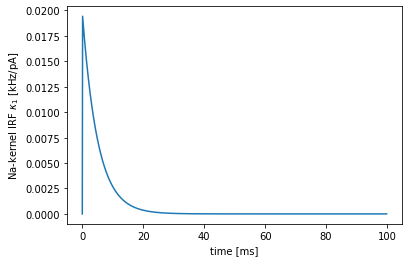

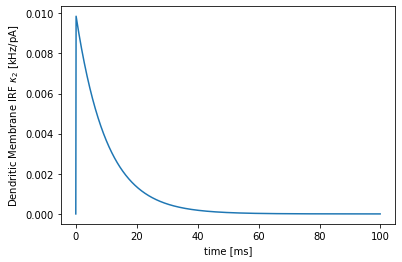

In [ ]:
tauNa = 5 # filter for sodium spikes
NaFilter,tfilt = DesignExponentialFilter(pars,tauNa)
plot(tfilt,NaFilter)
xlabel('time [ms]')
ylabel('Na-kernel IRF $\kappa_1$ [kHz/pA]')

figure()
tauDmem = 10 # filter for sodium spikes
DMemFilter,tfilt = DesignExponentialFilter(pars,tauDmem)
plot(tfilt,DMemFilter)
xlabel('time [ms]')
ylabel('Dendritic Membrane IRF $\kappa_2$ [kHz/pA]')

Input Gaussian White Noise

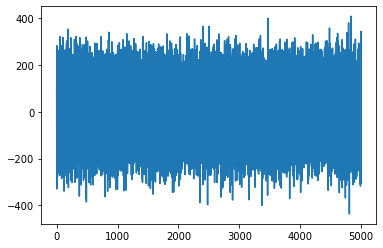

In [ ]:
I = my_GWN(pars, 0, 1, myseed=False)
plot(pars['range_t'],I)


Text(0, 0.5, '$V_d$ [mV]')

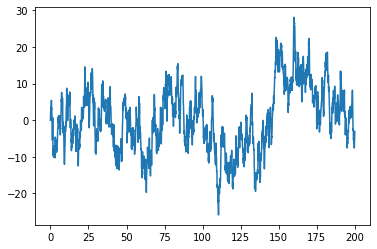

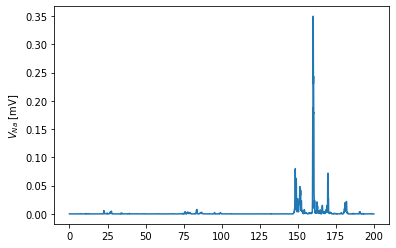

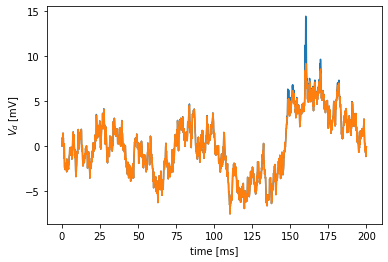

In [ ]:

INa_pre = lfilter(NaFilter, 1, I, axis=- 1, zi=None)
plot(pars['range_t'][:2000],INa_pre[:2000])

NL_baseline = 30
NL_sensit = 3
NL_scale = 15.0

VNa = sigmoid((INa_pre-NL_baseline)/NL_sensit)
figure()
plot(pars['range_t'][:2000],VNa[:2000])
ylabel('$V_{Na}$ [mV]')

VL = lfilter(DMemFilter, 1, I, axis=- 1, zi=None)/2
Vd = VL + VNa*NL_scale
figure()
plot(pars['range_t'][:2000],Vd[:2000])
plot(pars['range_t'][:2000],VL[:2000])
xlabel('time [ms]')
ylabel('$V_d$ [mV]')


Now look at dependence on mean input

## 1.2 EPSC train

Simulating EPSC train as in Magee papers

## 1.3 Interactions with soma
As in Golding paper

# 2 Ca spikes

Together, Larkum 1999 and Larkum 2004 show that dendritic input affects the gain of somatic output when the two are presented at the same time. We can capture this by multiplying the somatic and dendritic voltages. $b$ sets the gain of somatic input when $V_{dend} = 0$.

\begin{align}
\rho(t) &= \sigma \left( V_{soma}(t) [\text{relu}(V_{dend}(t)) + b] \right) \\
\rho(t) &= \sigma \left( (\kappa_{soma} * I_{soma}(t))(\text{relu}(\kappa_{dend} * I_{dend}(t)) + b) \right)
\end{align}

In [2]:
from typing import Callable

import numpy as np
import matplotlib.gridspec as gs
from ezephys import stimtools as st
from ezephys import pltools

def relu(x: ndarray) -> ndarray:
  assert x.ndim == 1
  return np.max([zeros_like(x), x], axis=0)

def get_filter(kernel: ndarray) -> Callable[[ndarray], ndarray]:
  """Get a function that convolves the kernel with an input."""
  return lambda input_: lfilter(kernel, 1, input_, axis=-1, zi=None)

def get_larkum_model(
  somatic_kernel: ndarray, dendritic_kernel: ndarray, base_gain: float
) -> Callable[[ndarray, ndarray], ndarray]:
  soma_filter = get_filter(somatic_kernel)
  dendritic_filter = get_filter(dendritic_kernel)

  def larkum_model(somatic_input: ndarray, dendritic_input: ndarray) -> ndarray:
    assert ndim(somatic_input) == 1
    assert ndim(dendritic_input) == 1
    
    activation = (
      soma_filter(somatic_input) 
      * (relu(dendritic_filter(dendritic_input)) + base_gain)
    )
    return sigmoid(activation)
    
  return larkum_model

In [3]:
larkum_model = get_larkum_model(DesignExponentialFilter(pars, 10)[0], DesignExponentialFilter(pars, 10)[0], 1)

In [4]:
synaptic_kernel = st.BiexponentialSynapticKernel(1, 0.1, 5, duration=25., dt=pars['dt'])

def delayed_pulse(delay: float, total_duration: float = 125.) -> st.ConvolvedStimulus:
    """Create ConvolvedStimulus containing a synaptic pulse with a delayed start."""
    pulse_time = np.zeros(int(total_duration / pars['dt'] - 0.5))
    pulse_time[int(delay / pars['dt'] - 0.5)] = 1.
    pulse = st.ConvolvedStimulus(0, synaptic_kernel)
    pulse.generate(pulse_time, pars['dt'])
    return pulse

## 2.1 Coincidence detection

Old title: interaction with soma.

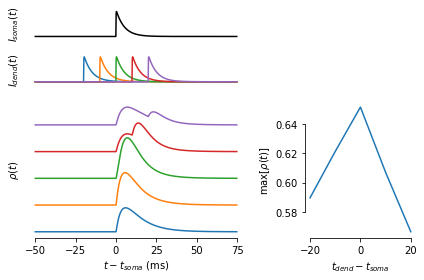

In [5]:
somatic_pulse_time = 50.
somatic_input = delayed_pulse(somatic_pulse_time)

fig_grid = gs.GridSpec(3, 2, height_ratios=[0.2, 0.2, 1], width_ratios=[1, 0.5])

plt.subplot(fig_grid[0, 0])
somatic_input.plot(color='k', label='Somatic input')
pltools.hide_border()
plt.ylabel('$I_{soma}(t)$')
plt.xlabel('')

input_ax = plt.subplot(fig_grid[1, 0])
pltools.hide_border()

output_ax = plt.subplot(fig_grid[2, 0])
output_ax.set_ylabel('$\\rho(t)$')

max_responses = []
for i, delay in enumerate(np.arange(30, 75, 10)):
    dend_pulse = delayed_pulse(delay)
    dend_pulse.plot(ax=input_ax)
    
    response = larkum_model(somatic_input.command.flatten(), 5 * dend_pulse.command.flatten())
    max_responses.append((delay - somatic_pulse_time, response.max()))
    output_ax.plot(
        somatic_input.time_supp - somatic_pulse_time, 
        i * 0.1 + response
    )
    
# Set axis labels for traces.
input_ax.set_xlabel('')
input_ax.set_ylabel('$I_{dend}(t)$')
output_ax.set_xlabel('$t - t_{soma}$ (ms)')
pltools.hide_border('trl', trim=True, ax=output_ax)

max_responses = np.array(max_responses)

plt.subplot(fig_grid[2, 1])
plt.plot(max_responses[:, 0], max_responses[:, 1])
plt.xlabel('$t_{dend} - t_{soma}$')
plt.ylabel('$\\mathrm{max}[\\rho(t)]$')
pltools.hide_border('tr', trim=True)

plt.tight_layout()

## 2.1 Noisy stimulation

As in Larkum et a. 2006

Emerson: I think you mean demonstration of gain as in Larkum 2004.

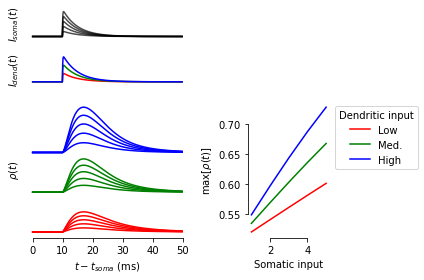

In [7]:
# Set up graded inputs
graded_input = delayed_pulse(10, 50)
graded_input.replicate(5)
intensities = np.arange(1, 6, 1)
graded_input.command *= intensities[:, np.newaxis]

# Generat figure
fig_grid = gs.GridSpec(3, 2, height_ratios=[0.2, 0.2, 1], width_ratios=[1, 0.5])

plt.subplot(fig_grid[0, 0])
plt.plot(graded_input.command.T, color='k', alpha=0.7)
pltools.hide_border()
plt.ylabel('$I_{soma}(t)$')
plt.xlabel('')

input_ax = plt.subplot(fig_grid[1, 0])
plt.plot(graded_input.command[0, :], color='r')
plt.plot(graded_input.command[1, :], color='g')
plt.plot(graded_input.command[2, :], color='b')
pltools.hide_border()

output_ax = plt.subplot(fig_grid[2, 0])
output_ax.set_ylabel('$\\rho(t)$')

max_responses = []
for i, (color, dendritic_intensity) in enumerate(zip(['r', 'g', 'b'], range(0, 5, 2))):
    for somatic_intensity in range(0, 5):
        response = larkum_model(
            0.2 * graded_input.command[somatic_intensity, :].flatten(), 
            2 * graded_input.command[dendritic_intensity, :].flatten()
        )
        max_responses.append(response.max())
        output_ax.plot(
            graded_input.time_supp,
            i * 0.2 + response,
            color=color
        )
    
# Set axis labels for traces.
input_ax.set_xlabel('')
input_ax.set_ylabel('$I_{dend}(t)$')
output_ax.set_xlabel('$t - t_{soma}$ (ms)')
pltools.hide_border('trl', trim=True, ax=output_ax)

max_responses = np.reshape(max_responses, (3, 5))

plt.subplot(fig_grid[2, 1])
for i, (col, lab) in enumerate(zip(['r', 'g', 'b'], ['Low', 'Med.', 'High'])):
    plt.plot(intensities, max_responses[i], color=col, label=lab)
plt.legend(title='Dendritic input', loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Somatic input')
plt.ylabel('$\\mathrm{max}[\\rho(t)]$')
pltools.hide_border('tr', trim=True)

plt.tight_layout()

## 2.3 EPSC trains

Hmm, I actually dont know of any papers eliciting Ca spikes with EPSC trains in dendrites only... maybe skip for now?

# 3 NMDA spikes

Even longer timescale

## 3.1 Noisy stimulation

Hmm, I dont know which experimental paper did NMDA and noisy stim. But there must be something.

## 3.2 EPSC trains

Major model figures and Schiller paper (s)

## 3.3 Interaction with soma
I dont think there is any experiments on this, but could be good to explore by modeling for symmetry

# 4 Interaction among dendritic spikes

Expose some features of Parallel information processing, as in the Ujfalussy et al. model

# 4.1 Na and Ca spikes

## 4.2 Na and NMDA spikes
